# Import necessary libraries

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

# Define the Generator

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels=3):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.img_channels = img_channels

        self.model = nn.Sequential(
            # Starting size: (latent_dim, 1, 1)
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # Size: (512, 4, 4)
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # Size: (256, 8, 8)
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # Size: (128, 16, 16)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Size: (64, 32, 32)
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # Final size: (img_channels, 64, 64)
        )

    def forward(self, z):
        z = z.view(z.size(0), self.latent_dim, 1, 1)
        return self.model(z)

# Define the Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # Input size: (img_channels, 64, 64)
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Size: (64, 32, 32)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # Size: (128, 16, 16)
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # Size: (256, 8, 8)
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # Size: (512, 4, 4)
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # Output size: (1, 1, 1)
        )

    def forward(self, img):
        return self.model(img).view(-1, 1)

# Cat Dataset

In [8]:
class CatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            if os.path.isdir(folder_path):
                for file in os.listdir(folder_path):
                    if file.endswith('.jpg'):
                        self.image_files.append(os.path.join(folder_path, file))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image


# Training function

In [9]:
def train_gan(generator, discriminator, dataloader, num_epochs, latent_dim, device):
    adversarial_loss = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    g_losses = []
    d_losses = []

    for epoch in range(num_epochs):
        for i, imgs in enumerate(dataloader):
            batch_size = imgs.size(0)
            real = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)

            real_imgs = imgs.to(device)

            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_imgs = generator(z)
            g_loss = adversarial_loss(discriminator(gen_imgs), real)
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(real_imgs), real)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            if i % 50 == 0:
                print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
                g_losses.append(g_loss.item())
                d_losses.append(d_loss.item())

        # Plot the loss graph
        clear_output(wait=True)
        plt.figure(figsize=(10,5))
        plt.title("Generator and Discriminator Loss During Training")
        plt.plot(g_losses, label="Generator")
        plt.plot(d_losses, label="Discriminator")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.legend()
        display(plt.gcf())
        plt.close()

        # Generate and display a sample image
        with torch.no_grad():
            gen_imgs = generator(torch.randn(1, latent_dim).to(device)).cpu()
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.title(f"Generated Image at Epoch {epoch}")
        plt.imshow(np.transpose(gen_imgs[0].numpy(), (1, 2, 0)))
        display(plt.gcf())
        plt.close()

    return generator, discriminator

# Main execution

Hyperparameters

In [12]:
latent_dim = 100
img_channels = 3
batch_size = 64
num_epochs = 200

Device configuration

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


Initialize models

In [14]:
generator = Generator(latent_dim, img_channels).to(device)
discriminator = Discriminator(img_channels).to(device)

Load and preprocess the dataset

In [16]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = CatDataset(root_dir="C:\\Users\\osyed\\OneDrive\\Desktop\\AIML Assessment project", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Dataset size: {len(dataset)} images")

Dataset size: 9997 images


Train the GAN

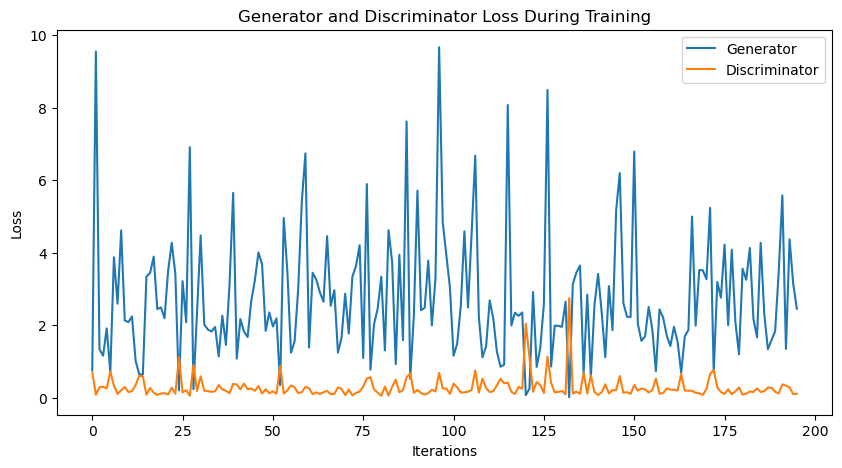

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


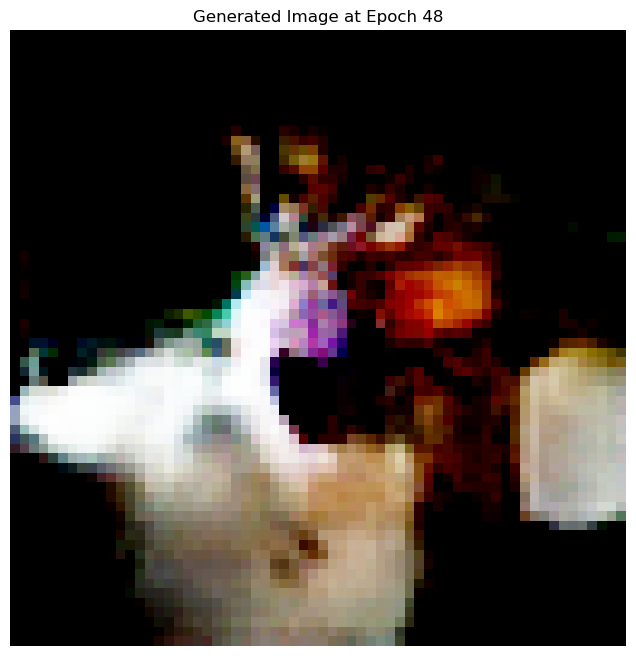

[Epoch 49/200] [Batch 0/157] [D loss: 0.1155] [G loss: 2.2153]


In [ ]:
generator, discriminator = train_gan(generator, discriminator, dataloader, num_epochs, latent_dim, device)

Save the trained models

In [ ]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

print("Training completed. Models saved.")

# Generate a final set of images

In [ ]:
n_rows = 5
n_cols = 5
n_samples = n_rows * n_cols

z = torch.randn(n_samples, latent_dim).to(device)
generated_images = generator(z).cpu().detach()

# Plot the images

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(n_samples):
    plt.subplot(n_rows, n_cols, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(generated_images[i], (1, 2, 0)))
plt.tight_layout()
display(plt.gcf())
plt.close()

print("Final generated images displayed.")